### Install dependencies and set global options

In [ ]:
!pip3 install html2text
!pip3 install pyLDAvis
!pip3 install --upgrade gensim
!pip3 install umap-learn

     |████████████████████████████████| 1.7MB 7.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.3MB 265kB/s 
     |████████████████████████████████| 9.9MB 42.3MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-cp37-none-any.whl size=136870 sha256=060815b8194f81a0ff7236fdffe2bf003d3142fab2486e5734f1090742a55133
  Stored in directory: /root/.cache/pip/wheels/a0/9c/fc/c6e00689d35c82cf96a8adc70edfe7ba7904374fdac3240ac2
Successfully built pyLDAvis
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0

     |████████████████████████████████| 23.9MB 50.2MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
  Created wheel for umap: filename=umap-0.1.1-cp37-none-any.whl size=3568 sha256=479926cca50aafd788fd9c744bf597e97ed1b631fdbcedb5da4900e90139e3bf
  Stored in directory: /root/.cache/pip/wheels/7b/29/33/b4d917dc95f69c0a060e2ab012d95e15db9ed4cc0b94ccac26
Successfully built umap


In [ ]:
# General utilities
import pandas as pd
pd.set_option('display.max_colwidth', None) 
from pprint import pprint
import numpy as np
import pickle 
import matplotlib.pyplot as plt
from itertools import islice

# Data cleaning
from html2text import HTML2Text
import re

# NLP
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# LDA visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Machine Learning
import tensorflow as tf
import tensorflow_hub as hub

# Dimensionality Reduction
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

#Clustering
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_samples, silhouette_score




/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).ep

### Global Parameters

In [ ]:
#@markdown  # Global Parameters
#@markdown  ## New preprocessing necessary?
#@markdown  If box is checked, data is preprocessed. Otherwise cleaned data is loaded from disk.
new_preprocessing = False #@param {type:"boolean"}
#@markdown ## Show description of data file
show_description = True #@param {type:"boolean"}

##Load Data

In [ ]:
import os
os.chdir(os.path.expanduser('~'))
import gdown
zip_folder_name = 'youtube_comments_climate_change'

shared_google_drive_link = 'https://drive.google.com/uc?id=1vca7QCLO6oMkbKiK_8Xa7IJj0HhqkEb3'
output = zip_folder_name+'.zip'
gdown.download(shared_google_drive_link,output, quiet=False)

import zipfile
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('')


os.chdir(zip_folder_name) 

data_desciption_file = 'data_description.txt'

with open(data_desciption_file,'r') as myfile:
  f = myfile.read()
if show_description:
  print(f)

Downloading...
From: https://drive.google.com/uc?id=1vca7QCLO6oMkbKiK_8Xa7IJj0HhqkEb3
To: /root/youtube_comments_climate_change.zip
114MB [00:01, 98.0MB/s]


Data description
__________________

// Project
data deluge

// Data mining
All data are extracted using the YouTube Data Tools (YTDT):
https://tools.digitalmethods.net/netvizz/youtube/
Specifically, comments are extracted using the video info and comments module
https://tools.digitalmethods.net/netvizz/youtube/mod_video_info.php

// Datasets

- videoinfo_xE0KtLy5j8w_2018_06_26-18_32_17_comments.xlsx
This dataset includes all text posted within the comments section of the video https://youtu.be/xE0KtLy5j8w (produced by Climate Central, featured by The Daily Conversation)
Additional variables such as time of posting, replies, likes, etc. have been removed from the dataset.
The comments were then coded by hand, in order to identify particular coping strategies of people making sense of the information shown in the video (sea level rise scenarios).

- videoinfo_VbiRNT_gWUQ_2020_01_16-10_08_40_comments.tab
Data gathered from the video https://youtu.be/VbiRNT_gWUQ, produced by the National 

### Open file as df and removing unused columns



In [ ]:
if new_preprocessing:
  path = "videoinfo_VbiRNT_gWUQ_2020_01_16-10_08_40_comments.tab - videoinfo_VbiRNT_gWUQ_2020_01_16-10_08_40_comments.tab.csv"
  data = pd.read_csv(path, sep=",", encoding='utf-8')
  data = data.dropna(subset=['text', 'authorName']) # drop rows with no content

  data=data.drop(['id', 'publishedAt', 'isReply', 'replyCount','likeCount','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'],axis=1) # drop unused columns
else:
  path ="cleaned_data.csv"
  data = pd.read_csv(path, sep=",", encoding='utf-8')


## Preprocessing

In [ ]:
from tqdm import tqdm
tqdm.pandas()

if new_preprocessing:
  # clean html tags
  h = HTML2Text()
  h.ignore_links = True
  data['cleaned'] = data['text'].progress_apply(lambda x: h.handle(x))

  # removing links
  http_link_pattern = r'http\S+'
  bitly_link_pattern = r'bit.ly/\S+'
  data['cleaned'] = data['cleaned'].str.replace(http_link_pattern, '')
  data['cleaned'] = data['cleaned'].str.replace(bitly_link_pattern, '')

  # removing escape characters
  for i, row in data.iterrows():
    data.at[i,'cleaned'] = data.at[i,'cleaned'].replace("\n", " ")
    data.at[i,'cleaned'] = data.at[i,'cleaned'].replace("\t", " ")

data.head()

,Unnamed: 0,publishedAt,authorName,text,isReply,cleaned
0,0,2020-01-16 09:01:08,Lee McLellan,If all the ice melts surely the tilt of the earth will also change because of\nthe weight diffrence at both poles ? And would this affect the land mass to\nchange also?\n\n,0,If all the ice melts surely the tilt of the earth will also change because of\nthe weight diffrence at both poles ? And would this affect the land mass to\nchange also?\n\n
1,1,2020-01-16 06:16:07,Aakash Majumdar,The scariest part of the video is the music..... How dramatic the music is...\n\n,0,The scariest part of the video is the music..... How dramatic the music is...\n\n
2,2,2020-01-15 10:50:21,Glenn Davies,"New Zealand be like...""are we good?"" 🤷‍♂️\n\n",0,"New Zealand be like...""are we good?"" 🤷‍♂️\n\n"
3,3,2020-01-15 08:35:50,Shane Meyer,Step #1: Taxes... Step #2: ???... Step #3: Utopia\n\n,0,Step #1: Taxes... Step #2: ???... Step #3: Utopia\n\n
4,4,2020-01-15 02:00:30,Rennie Allen,Strange how Hudson's Bay stayed the same size.\n\n,0,Strange how Hudson's Bay stayed the same size.\n\n


## Topic Modelling

### Models-specific preprocessing

In [ ]:
#@markdown #Clear usernames from comments
clean_usernames = False #@param {type:"boolean"}
#@markdown # Add username to list of names kept
#@markdown Run this cell after adding username to keep
keep_name = "" #@param {type:"string"}

In [ ]:
if clean_usernames:
  keep_names = ["earth", "Tide", "Geologist", "A Person", "Titanic", "adventure", "Sun", "The United States Of America", "Dawn", "Canada"]
  keep_names.append(keep_name)
  user_names = [name for name in data['authorName'].unique() if (len(name)> 3 and name not in keep_names)]

  data['cleaned_lda'] = data['cleaned'].str.replace('|'.join(map(re.escape, user_names)), '')
else:
  data['cleaned_lda'] = data['cleaned']

In [ ]:
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@#'
tqdm.pandas()

def clean_text(text):
  # lowercase text
  text = text.lower()

  # strip punctuation
  text = re.sub('['+punctuation + ']+', ' ', text)

  # remove double spacing
  text = re.sub(' +', ' ', text)
  
  # remove numbers
  text = re.sub('([0-9]+)', '', text)
  
  return text

data['cleaned_lda'] = data['cleaned_lda'].progress_apply(clean_text)

100%|██████████| 25914/25914 [00:00<00:00, 53512.75it/s]


#### Tokenizing



In [ ]:
def send_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))

data_words = list(send_to_words(data['cleaned_lda']))

In [ ]:
#@markdown #Display comment as a "tokenized" list of words
index = 10 #@param {type:"integer"}

data_words[index]

['florida', 'and', 'delaware', 'aight', 'imma', 'head', 'out']

#### N-grams

In [ ]:
#@markdown An n-gram is a contiguous sequence of items in this case words. A bigram consists of two words, a trigram of three words.
#@markdown The gensim Phrase detection automatically detects common sequences.

#@markdown Important params for these n-grams are min_count and threshold. The higher these params harder it is for words to be combined.

#@markdown ### Use trigrams
use_trigrams = False #@param {type:"boolean"}

#@markdown ### Adjust n-gram parameters
min_count= 5 #@param {type:"integer"}
threshold = 100 #@param {type:"integer"}


In [ ]:
bigram = gensim.models.Phrases(data_words, min_count=min_count, threshold=threshold)
bigram_mod = gensim.models.phrases.Phraser(bigram)

if use_trigrams:
  trigram = gensim.models.Phrases(bigram[data_words], threshold=threshold) 
  trigram_mod = gensim.models.phrases.Phraser(trigram)

#### Removing stop words, lemmatization

For using manually assembled stoplist, exchange "stop_words" for "stop_words_manually" in line 11

In [ ]:
#@markdown #Stoplists
#@markdown Use NLTK stoplist
use_nltk_stoplist = True #@param {type:"boolean"}
#@markdown Use manually assembled stoplist
use_manual_stoplist = True #@param {type:"boolean"}

In [ ]:
def remove_stopwords_nltk(texts):
  stop_words = stopwords.words('english')
  
  return [[word for word in simple_preprocess(str(elem)) if word not in stop_words] for elem in texts]

def remove_stopwords_manual(texts):
  path = "stoplist.txt"
  with open(path, encoding="utf16") as f:
    stop_words_manually = f.read().splitlines()

  return [[word for word in simple_preprocess(str(elem)) if word not in stop_words_manually] for elem in texts]  

def make_bigrams(texts):
    return [bigram_mod[elem] for elem in texts]

def make_trigrams(texts):
    return [trigram_mod[elem] for elem in texts]

def lemmatization(texts, allowed_postags):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
if use_nltk_stoplist:
  data_words_nostops = remove_stopwords_nltk(data_words)
else:
  data_words_nostops = data_words

if use_manual_stoplist:
  data_words_nostops = remove_stopwords_manual(data_words_nostops)

data_words_ngrams = make_bigrams(data_words_nostops)

if use_trigrams:
  data_words_ngrams = make_trigrams(data_words_ngrams)

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# During lemmatization only nouns, adjectives, verbs, and adverbs are kept.
data_lemmatized = lemmatization(data_words_ngrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
#@markdown #Display comment as a "lemmatized" list of words
index = 16 #@param {type:"integer"}

print("Original comment: {} \n Cleaned comment: {}".format(data['text'][index], data_lemmatized[index]))

Original comment: this isn’t funny. doesn’t anybody care about the earth??

 
 Cleaned comment: ['funny', 'care', 'earth']


### LDA

The gensim LDA model needs dictionary(id2word) and corpus. The dictionary creates an unique id for all words, the corpus maps the id to the number of occurences in the model.

In [ ]:
id2word = corpora.Dictionary(data_lemmatized)

texts = data_lemmatized

corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
#@markdown #Show frequency of tokens in a comment
index = 12 #@param {type:"integer"}

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[index:index+1]]

[[('would', 1), ('look', 1)]]

#### Building a first model

Aside from corpus and dictionary, the model takes the number of topics, chunksize (number of documents to be used in each training chunk increasing chunksize speed up training), and passes (epochs) as input.

In [ ]:
num_topics = 5
chunksize = 100
passes = 10

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, 
                                       random_state=100,
                                       chunksize=chunksize,
                                       passes=passes,
                                       per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.056*"go" + 0.032*"live" + 0.026*"get" + 0.025*"show" + 0.021*"still" + '
  '0.019*"city" + 0.018*"good" + 0.015*"move" + 0.015*"fuck" + 0.014*"would"'),
 (1,
  '0.061*"water" + 0.048*"ice" + 0.035*"level" + 0.034*"would" + 0.027*"sea" + '
  '0.022*"melt" + 0.021*"rise" + 0.015*"land" + 0.014*"change" + 0.013*"year"'),
 (2,
  '0.033*"know" + 0.031*"say" + 0.028*"people" + 0.027*"make" + 0.021*"think" '
  '+ 0.013*"want" + 0.013*"need" + 0.013*"year" + 0.012*"time" + '
  '0.012*"right"'),
 (3,
  '0.020*"use" + 0.018*"oil" + 0.017*"care" + 0.015*"tell" + 0.014*"life" + '
  '0.013*"even" + 0.012*"canadian" + 0.010*"exist" + 0.010*"could" + '
  '0.010*"first"'),
 (4,
  '0.043*"would" + 0.033*"happen" + 0.030*"country" + 0.027*"go" + '
  '0.026*"world" + 0.026*"see" + 0.024*"bad" + 0.024*"look" + 0.020*"video" + '
  '0.013*"state"')]


In [ ]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # the lower the better.

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
print('\nCoherence Score: ', coherence_model_lda.get_coherence())


Perplexity:  -7.733776155688975

Coherence Score:  0.5943537359666222


#### Hyperparameter Tuning

In [ ]:
def compute_coherence_values(corpus, dictionary, k, a, b):
  lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                          id2word=dictionary,
                                          num_topics=k, 
                                          random_state=100,
                                          chunksize=100,
                                          passes=10,
                                          alpha=a,
                                          eta=b)
  
  coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
  
  return (coherence_model_lda.get_coherence(), lda_model.log_perplexity(corpus))

In [ ]:
#@markdown #Create new hyperparameter tuning results?
#@markdown Beware, tuning takes ~2h. Results of prior tuning can be inspected further down.
hyperparameter_tuning = False#@param {type:"boolean"}

In [ ]:
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)

corpus_sets = [corpus] 

corpus_title = ['100% Corpus']

model_results = {'Validation_Set': [],
                'Topics': [],
                'Alpha': [],
                'Beta': [],
                'Coherence': [],
                'Perplexity': []
                }

# Can take a long time to run
if hyperparameter_tuning:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
      # iterate through number of topics
      for k in topics_range:
        # iterate through alpha values
        for a in alpha:
          # iterare through beta values
          for b in beta:
            # get the coherence score for the given parameters
            cv, perp = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                          k=k, a=a, b=b)
            # Save the model results
            model_results['Validation_Set'].append(corpus_title[i])
            model_results['Topics'].append(k)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)
            model_results['Perplexity'].append(perp)
            
            pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

#### Analyzing results of hyperparameter tuning

In [ ]:
path = "lda_tuning_results_new.csv"
lda_results = pd.read_csv(path, sep=",", encoding='utf-8')

list(lda_results.columns)

['Validation_Set', 'Topics', 'Alpha', 'Beta', 'Coherence', 'Perplexity']

In [ ]:
lda_results

,Validation_Set,Topics,Alpha,Beta,Coherence,Perplexity
0,100% Corpus,2,0.01,0.01,0.628453,-21.209499
1,100% Corpus,2,0.01,0.31,0.634792,-7.268904
2,100% Corpus,2,0.01,0.61,0.627053,-7.269150
3,100% Corpus,2,0.01,0.9099999999999999,0.635476,-7.295884
4,100% Corpus,2,0.01,symmetric,0.639064,-7.277123
...,...,...,...,...,...,...
565,100% Corpus,20,asymmetric,0.01,0.458815,-21.249133
566,100% Corpus,20,asymmetric,0.31,0.554936,-7.669183
567,100% Corpus,20,asymmetric,0.61,0.555322,-7.605930
568,100% Corpus,20,asymmetric,0.9099999999999999,0.524825,-7.628414


In [ ]:
#@markdown # Display tuning graphs for various alpha and beta values
alpha_value="asymmetric" #@param ["0.01", "0.31", "0.61", "0.9099999999999999", "symmetric", "asymmetric"]
beta_value="0.61" #@param ["0.01", "0.31", "0.61", "0.9099999999999999", "symmetric", "asymmetric"]

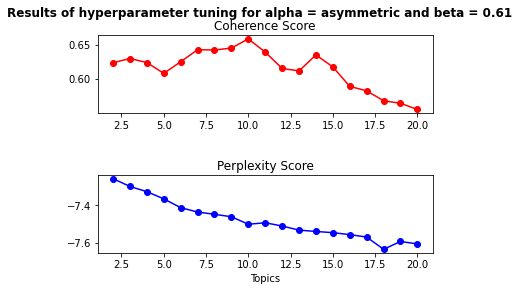

Best overall coherence scores:



,Validation_Set,Topics,Alpha,Beta,Coherence,Perplexity
15,100% Corpus,2,0.9099999999999999,0.01,0.685963,-22.318926
89,100% Corpus,4,asymmetric,symmetric,0.682872,-7.299179
45,100% Corpus,3,0.9099999999999999,0.01,0.673557,-22.245306
10,100% Corpus,2,0.61,0.01,0.667774,-22.320651
47,100% Corpus,3,0.9099999999999999,0.61,0.665189,-7.304132
109,100% Corpus,5,0.9099999999999999,symmetric,0.663300,-7.287105
85,100% Corpus,4,asymmetric,0.01,0.661986,-22.266786
20,100% Corpus,2,symmetric,0.01,0.661755,-22.307289
86,100% Corpus,4,asymmetric,0.31,0.661685,-7.278117
238,100% Corpus,9,asymmetric,0.9099999999999999,0.660548,-7.511356


In [ ]:
coherence = lda_results.loc[np.logical_and(lda_results.Alpha == alpha_value, lda_results.Beta == beta_value)]['Coherence']
perplexity = lda_results.loc[np.logical_and(lda_results.Alpha == alpha_value, lda_results.Beta == beta_value)]['Perplexity']
topics = lda_results.loc[np.logical_and(lda_results.Alpha == alpha_value, lda_results.Beta == beta_value)]['Topics']

fig, axs = plt.subplots(2)
fig.suptitle('Results of hyperparameter tuning for alpha = {} and beta = {}'.format(alpha_value, beta_value), fontweight="bold")
fig.subplots_adjust(hspace=0.8)
axs[0].plot(topics, coherence, linestyle='-', marker='o', color="red")
axs[0].set_title("Coherence Score")
axs[1].plot(topics, perplexity, linestyle='-', marker='o', color="blue")
axs[1].set_title("Perplexity Score")

plt.xlabel('Topics')
plt.show()

print("Best overall coherence scores:\n")
lda_results.nlargest(30, 'Coherence')

#### Building a model with tuned parameters

In [ ]:
#@markdown # Build new model with tuned parameters
alpha_value="asymmetric" #@param [0.01, 0.31, 0.61, 0.9099999999999999, "symmetric", "asymmetric"]
beta_value="0.9099999999999999" #@param [0.01, 0.31, 0.61, 0.9099999999999999, "symmetric", "asymmetric"]
nr_topics=9 #@param {type:"integer"}

In [ ]:
tuned_lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=nr_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha_value,
                                           eta=float(beta_value))

pprint(tuned_lda_model.print_topics())
doc_tuned_lda = tuned_lda_model[corpus]

[(0,
  '0.026*"go" + 0.019*"would" + 0.016*"people" + 0.012*"know" + 0.011*"get" + '
  '0.011*"think" + 0.010*"world" + 0.010*"say" + 0.010*"live" + 0.010*"look"'),
 (1,
  '0.052*"water" + 0.041*"ice" + 0.029*"level" + 0.025*"would" + 0.023*"sea" + '
  '0.018*"melt" + 0.018*"rise" + 0.013*"year" + 0.011*"earth" + 0.011*"land"'),
 (2,
  '0.018*"oil" + 0.015*"give" + 0.011*"energy" + 0.011*"use" + 0.010*"forget" '
  '+ 0.010*"s" + 0.010*"money" + 0.007*"food" + 0.007*"power" + '
  '0.007*"source"'),
 (3,
  '0.009*"ciudade" + 0.008*"hater" + 0.008*"silly" + 0.007*"como" + '
  '0.006*"untouched" + 0.005*"paise" + 0.005*"fake" + 0.005*"son" + '
  '0.005*"dude" + 0.004*"skip"'),
 (4,
  '0.021*"leave" + 0.014*"town" + 0.006*"property" + 0.004*"language" + '
  '0.004*"spell" + 0.004*"tale" + 0.004*"screw" + 0.004*"irrelevant" + '
  '0.003*"discussion" + 0.003*"value"'),
 (5,
  '0.029*"music" + 0.013*"flat" + 0.004*"buenos_aire" + 0.004*"track" + '
  '0.004*"eat" + 0.003*"beautiful" + 0.002*"sc

In [ ]:
for i in tuned_lda_model.show_topics(formatted=False,num_topics=tuned_lda_model.num_topics,num_words=len(tuned_lda_model.id2word)):
    print(i)

(0, [('go', 0.025990944), ('would', 0.019370284), ('people', 0.015607698), ('know', 0.011585883), ('get', 0.010958135), ('think', 0.010749879), ('world', 0.01048061), ('say', 0.010438242), ('live', 0.010373197), ('look', 0.009953615), ('make', 0.009389082), ('country', 0.009055957), ('city', 0.008781371), ('happen', 0.008685678), ('see', 0.007726185), ('video', 0.007649305), ('even', 0.0075792675), ('bad', 0.007295958), ('show', 0.0068857423), ('come', 0.0061593573), ('thing', 0.0061335), ('still', 0.0058513368), ('good', 0.0056914543), ('time', 0.0055321166), ('really', 0.005306804), ('move', 0.004887964), ('flood', 0.0048733605), ('want', 0.004701466), ('fuck', 0.0046418537), ('need', 0.0046240645), ('way', 0.0044109323), ('right', 0.004353078), ('lol', 0.004136656), ('well', 0.004068673), ('planet', 0.0039744894), ('place', 0.0039612525), ('also', 0.0039157546), ('big', 0.0038816724), ('care', 0.003815074), ('take', 0.003727054), ('year', 0.0036881885), ('human', 0.003599733), ('lot

### Analyzing LDA


#### PyLDAvis
Each blue circle represents a topic. The larger the bubble, the more prevalent the topic.

Relatively big, non-overlapping bubbles scattered throughout the chart are desirable.

By decreasing the value of lamda, more weight is put on the ratio of frequency given the topic to overall frequency of the word.

In [ ]:
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(tuned_lda_model, corpus, id2word)

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.289143  0.148396       1        1  52.844179
1     -0.228471 -0.178174       2        1  31.975516
3      0.064427  0.009038       3        1   3.222903
2      0.084113  0.008610       4        1   3.057098
4      0.074910  0.005543       5        1   2.090202
7      0.070445  0.007081       6        1   2.037634
6      0.071262 -0.001442       7        1   1.933214
5      0.073938 -0.001704       8        1   1.553657
8      0.078519  0.002652       9        1   1.285596, topic_info=             Term         Freq        Total Category  logprob  loglift
51          water  2845.000000  2845.000000  Default  30.0000  30.0000
5             ice  2258.000000  2258.000000  Default  29.0000  29.0000
72          level  1616.000000  1616.000000  Default  28.0000  28.0000
229           sea  1281.000000  1281.000000  Default  27.0000  27.0000
83             go  2312.000000  2312.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
7956        igual     3.996588    21.264409   Topic9  -6.3302   2.6824
9550          tar     3.227298    17.976592   Topic9  -6.5440   2.6365
3032   accusation     3.302957    24.979568   Topic9  -6.5209   2.3307
68           walk     3.390724    44.477844   Topic9  -6.4946   1.7800
10993       usted     2.668686    14.081617   Topic9  -6.7341   2.6907

[437 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
2938       1  0.106154       abuse
2938       2  0.106154       abuse
2938       3  0.636925       abuse
3032       1  0.640523  accusation
3032       2  0.040033  accusation
...      ...       ...         ...
10861      2  0.141660        море
10861      8  0.566639        море
2606       1  0.182161      россии
2606       2  0.182161      россии
2606       5  0.546484      россии

[1198 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3, 5, 8, 7, 6, 9])

#### Calculating most representative topic for each comment
Index shows original placement of commment. Takes about 2min to run.

In [ ]:
def show_comment_topics(ldamodel, corpus, documents):
    topics_data = pd.DataFrame()

    # Iterate over model corpus
    for index, row in tqdm(enumerate(ldamodel[corpus])):
        # Sort topic distribution percentage desc
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for i, (topic_num, prop_topic) in enumerate(row):
            if i == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topics_data = topics_data.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break

    # Append original comment at the end
    contents = pd.Series(documents['text'])
    topics_data = pd.concat([topics_data, contents], axis=1)
    # Rename columns
    topics_data.columns = ['Dominant topic', '% of dominant topic in comment', ' Topic keywords', 'Comment']
    return(topics_data)

data_topic_keywords = show_comment_topics(tuned_lda_model, corpus, data)
data_topic_keywords.head(5)

25914it [02:34, 167.60it/s]


,Dominant topic,% of dominant topic in comment,Topic keywords,Comment
0,1.0,0.7922,"water, ice, level, would, sea, melt, rise, year, earth, land",If all the ice melts surely the tilt of the earth will also change because of\nthe weight diffrence at both poles ? And would this affect the land mass to\nchange also?\n\n
1,5.0,0.5439,"music, flat, buenos_aire, track, eat, beautiful, scary, wonderful, rid, motion",The scariest part of the video is the music..... How dramatic the music is...\n\n
2,0.0,0.6096,"go, would, people, know, get, think, world, say, live, look","New Zealand be like...""are we good?"" 🤷‍♂️\n\n"
3,4.0,0.6392,"leave, town, property, language, spell, tale, screw, irrelevant, discussion, value",Step #1: Taxes... Step #2: ???... Step #3: Utopia\n\n
4,1.0,0.7890,"water, ice, level, would, sea, melt, rise, year, earth, land",Strange how Hudson's Bay stayed the same size.\n\n


#### Most representative comments for each topic


In [ ]:
#@markdown # Display top comments for each topic
#@markdown Select a topic
topic=8 #@param {type:"slider", min:0.0, max:10.0, step:1.0}
threshold_slider = 0.58 #@param {type:"slider", min:0, max:1, step:0.01}
if float(topic) not in data_topic_keywords['Dominant topic'].unique(): 
  print("Please chose an existing topic:\n {}".format(data_topic_keywords['Dominant topic'].unique()))
print("Comments belonging over {}% to topic {}".format(threshold_slider, float(topic)))

Comments belonging over 0.58% to topic 8.0


In [ ]:
top_comments = data_topic_keywords.loc[(data_topic_keywords['% of dominant topic in comment'] >= threshold_slider) & (data_topic_keywords['Dominant topic'] == topic)].sort_values(by=['% of dominant topic in comment'], ascending=False)
print("There are {} comments that pass over the threshold.\n".format(len(top_comments)))

top_comments.tail(10)

There are 35 comments that pass over the threshold.



,Dominant topic,% of dominant topic in comment,Topic keywords,Comment
23337,8.0,0.8824,"laugh, lmfao, will, baby, cry, igual, warn, chilly, uste, traffic","+Rithrius *inaudiable grunts and mumbles* ""MANBEARPIG!!!"" *more inaudiable\ngrunts and mumbles*\n\n"
19434,8.0,0.8657,"laugh, lmfao, will, baby, cry, igual, warn, chilly, uste, traffic",Fueler ill lick yo ice cream... n u can lick my lolli-pop-pop-pop-pop-pop-pop\n\n
25057,8.0,0.8433,"laugh, lmfao, will, baby, cry, igual, warn, chilly, uste, traffic","Друзья успокойтесь! Одному моему знакомому говорили что он умрет от рака, \nа он умер от сердца! На все воля господня!\n\n"
20626,8.0,0.8430,"laugh, lmfao, will, baby, cry, igual, warn, chilly, uste, traffic",WOOO!!!! VANOSSGAMING WONT BE HARMED!!! #vanossforlife\n\n
25408,8.0,0.8426,"laugh, lmfao, will, baby, cry, igual, warn, chilly, uste, traffic","@Gonzalo Fuentes Hu pero usted con todo respeto es o se hace ? Estados unidos\nel país mas capitalista de la tierra y espera que hagan una critica buena ?\nque poco entiende de política internacional,pregúntele a los rusos que piensan\nde Argentina o a los chinos.Todo es política mas en un año de elecciones en\nargentina que le juego si llega a ganar un presidente derechista como van a\ncambiar de opinión lo que usted lee,ahora nomas como a usted le pintan a\nArgentina.Argentina es el tercer país en PBI Y el segundo en PBI per capital\nen latinoamerica el único país en latinoamerica en estar en el podio de los\ndos indicadores económicos mas inportantes.\n\n"
7594,8.0,0.8111,"laugh, lmfao, will, baby, cry, igual, warn, chilly, uste, traffic","Это меньшее и самое малое из того, чего нам стоит опасаться! Есть катастрофы\nкуда более серьёзные, чем потеря береговой линии!\n\n"
2423,8.0,0.8111,"laugh, lmfao, will, baby, cry, igual, warn, chilly, uste, traffic","Na ez egészen kicsit pontatlan, hogy csak ennyi víz alatti város lesz. \n \nArról nem is beszélve ha az Északi sark alatt lévő gáz.(ammónia, hélium)\nfelszabadul és oxigénnel elegyedik akkor nagy durranásra készülhet az\nEMBERISÉG...!!!\n\n"
25693,8.0,0.8099,"laugh, lmfao, will, baby, cry, igual, warn, chilly, uste, traffic","+Maria Donatello Holly shit you are delusional, you must be a republican\n\n"
25538,8.0,0.7649,"laugh, lmfao, will, baby, cry, igual, warn, chilly, uste, traffic","@***** A bueno, el sur es diferente. Quizá bastante influenciado por los\ncolonos alemanes la verdad, pero así cualquiera xD Igual viva Chile y aguanten\nlas sopaipillas en invierno :v\n\n"
13607,8.0,0.7642,"laugh, lmfao, will, baby, cry, igual, warn, chilly, uste, traffic",Summary: **cries silently**\n\n


#### Least representative commments for each topic

In [ ]:
#@markdown # Display least representative comments for each topic
#@markdown Select a topic
topic=0 #@param {type:"slider", min:0.0, max:10.0, step:1.0}
if float(topic) not in data_topic_keywords['Dominant topic'].unique(): 
  print("Please chose an existing topic:\n {}".format(data_topic_keywords['Dominant topic'].unique()))
print("Comments least representative of topic {}".format(float(topic)))

Comments least representative of topic 0.0


In [ ]:
data_topic_keywords.loc[data_topic_keywords['Dominant topic'] == topic].sort_values(by=['% of dominant topic in comment']).head(20)

,Dominant topic,% of dominant topic in comment,Topic keywords,Comment
13028,0.0,0.2193,"go, would, people, know, get, think, world, say, live, look",What about manitoba\n\n
5450,0.0,0.2193,"go, would, people, know, get, think, world, say, live, look",F in the chat for Florida\n\n
15598,0.0,0.2193,"go, would, people, know, get, think, world, say, live, look",.\n\n
5444,0.0,0.2193,"go, would, people, know, get, think, world, say, live, look",how about Philippines?\n\n
15609,0.0,0.2193,"go, would, people, know, get, think, world, say, live, look",Claudia Catarig e viata =)))\n\n
15616,0.0,0.2193,"go, would, people, know, get, think, world, say, live, look",North Somalia\n\n
15621,0.0,0.2193,"go, would, people, know, get, think, world, say, live, look",I like California's inland sea. And who's going to miss Florida?\n\n
5433,0.0,0.2193,"go, would, people, know, get, think, world, say, live, look",Islander here 👀\n\n
15626,0.0,0.2193,"go, would, people, know, get, think, world, say, live, look",Click bait\n\n
15629,0.0,0.2193,"go, would, people, know, get, think, world, say, live, look",This will be Trump's legacy\n\n


In [ ]:
data_topic_keywords.loc[(data_topic_keywords['% of dominant topic in comment'] == 0.2035) & (data_topic_keywords['Dominant topic'] == topic)]

,Dominant topic,% of dominant topic in comment,Topic keywords,Comment


#### Topic distribution over all comments

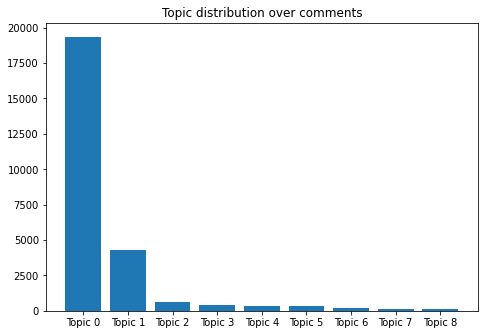

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

topic_count = data_topic_keywords['Dominant topic'].value_counts()

x = []
y = []

for i, topic in enumerate(topic_count):
    y.append(float(topic_count[i]))
    x.append('Topic {}'.format(i))

ax.bar(x,y)
ax.set_title('Topic distribution over comments')
plt.show()

In [ ]:
topic_count

0.0    19377
1.0     4294
2.0      654
3.0      380
5.0      371
4.0      358
6.0      202
7.0      152
8.0      126
Name: Dominant topic, dtype: int64

#### Show topic distribution for single comment

In [ ]:
#@markdown # Display topic distribution for each comment
#@markdown Select a comment
comment_id=2291 #@param {type:"integer"} 
get_document_topics = tuned_lda_model.get_document_topics(corpus)

Text(0.5, 1.0, 'Topic distribution in comment 2291')

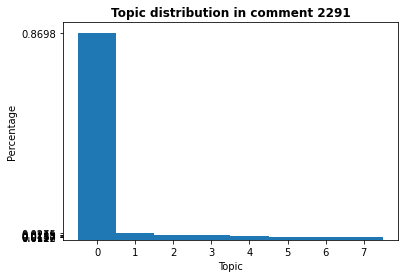

In [ ]:
top=get_document_topics[comment_id]

labels, y = zip(*top)
x = np.arange(len(labels)) 
width = 1

plt.bar(x, y, width, align='center')
plt.xticks(x, labels)
plt.yticks(y)
plt.ylabel("Percentage")
plt.xlabel("Topic")
plt.title("Topic distribution in comment {}".format(comment_id), fontweight="bold")

## Contextual Embeddings

### Universal Sentence Encoder

#### Loading the model


In [ ]:
output_path = "embeddings" #@param {type:'string'}
url_dict = {
            'Transformer' : "https://tfhub.dev/google/universal-sentence-encoder-large/5",
            'DAN' : "https://tfhub.dev/google/universal-sentence-encoder/4",
}

#@markdown  #Global Parameters
#@markdown # Produce new Embeddings?
#@markdown If new_embeddings is checked, data is preprocessed and new embeddings are produced (takes some time). Otherwise, Data is loaded from Disc
new_embeddings = False #@param {type:"boolean"}
model_type = "Transformer" #@param ["DAN", "Transformer"]


#@markdown Set the random seed to get reproducible results
set_random_seed = True #@param {type:"boolean"}
random_seed = 4 #@param {type:"number"}
if set_random_seed:
  np.random.seed(random_seed)

In [ ]:
hub_url = url_dict[model_type]

if new_embeddings:
  print("Loading model...")
  embed = hub.load(hub_url)
  print('Embedding...')

  for k,g in data.groupby(np.arange(len(data))//10):
    if k == 0:
      embeddings = embed(g['cleaned'])
    else:
      embeddings_new = embed(g['cleaned'])
      embeddings_new
      embeddings = tf.concat(values=[embeddings,embeddings_new],axis = 0)
    print(k)
  print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))
  
  np.save('embeddings_'+model_type.lower()+'.npy', embeddings, allow_pickle=True, fix_imports=True)
  
else:
  print("Loading embeddings...")
  embeddings = np.load('embeddings_'+model_type.lower()+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
  


Loading embeddings...


#### Printing embeddings for five comments

In [ ]:
#@markdown To display more comments change value of limit variable
limit = 5 #@param {type: "integer"}

for i, comment_embedding in islice(enumerate(np.array(embeddings).tolist()), limit):
  print("Comment: {}".format(data['cleaned'][i]))
  print("Embedding size: {}".format(len(comment_embedding)))
  comment_embedding_snippet = ", ".join(
      (str(x) for x in comment_embedding[:5]))
  print("Embedding: [{}, ...]\n".format(comment_embedding_snippet))

Comment: If all the ice melts surely the tilt of the earth will also change because of
the weight diffrence at both poles ? And would this affect the land mass to
change also?


Embedding size: 512
Embedding: [0.022679559886455536, -0.06716511398553848, 0.01718921773135662, -0.011964518576860428, -0.00821097381412983, ...]

Comment: The scariest part of the video is the music..... How dramatic the music is...


Embedding size: 512
Embedding: [0.041919998824596405, 0.07056527584791183, 0.09499478340148926, 0.052138879895210266, -0.03426333889365196, ...]

Comment: New Zealand be like..."are we good?" 🤷‍♂️


Embedding size: 512
Embedding: [-0.06692986935377121, -0.005417580250650644, -0.030794018879532814, -0.0252645555883646, 0.002292255638167262, ...]

Comment: Step #1: Taxes... Step #2: ???... Step #3: Utopia


Embedding size: 512
Embedding: [-0.009693004190921783, -0.027369067072868347, 0.01169059332460165, 0.010891173966228962, 0.031271807849407196, ...]

Comment: Strange how Hudson

#### Dimensionality reduction for clustering

In [ ]:
#@markdown #New dimensionality reduction
#@markdown If new_dimensions is checked, embedding vectors' dimensions are reduced to the value of n_components. Otherwise, Data is loaded from Disc
new_dimensions = False #@param {type:"boolean"}
n_components = 100 #@param {type:"integer"}
n_neighbors = 20 #@param [20, 30, 50]
min_dist = 0 #@param [0.0, 0.025, 0.05, 0.1, 0.2]

In [ ]:
if new_dimensions:
  print("UMAP is running...")
  reduced_embeddings = umap.UMAP(
      n_neighbors=n_neighbors,
      min_dist=min_dist,
      n_components=n_components
  ).fit_transform(embeddings)
else:
  print("Loading embeddings")
  reduced_embeddings = np.load('reduced_umap_100.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

Loading embeddings


In [ ]:
#@markdown Select normalize_data to normalize reduced embeddings vectors.
normalize_data = True #@param {type:"boolean"}

In [ ]:
if normalize_data:
  sc = StandardScaler()
  reduced_embeddings = sc.fit_transform(normalize(reduced_embeddings, norm='l2'))

### Agglomerative Clustering

In [ ]:
#@markdown #Linkage Criterion
#@markdown Select linkage type for Agglomerative Clustering dendrogram. The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion

#@markdown ‘Ward’ minimizes the variance of the clusters being merged, ‘average’ uses the average of the distances of each observation of the two sets.
linkage_type = "ward" #@param ["ward", "average"]

Z = sch.linkage(reduced_embeddings, linkage_type)

#@markdown Select the number of merged clusters to display.

lastp = 9 #@param {type:"integer"}


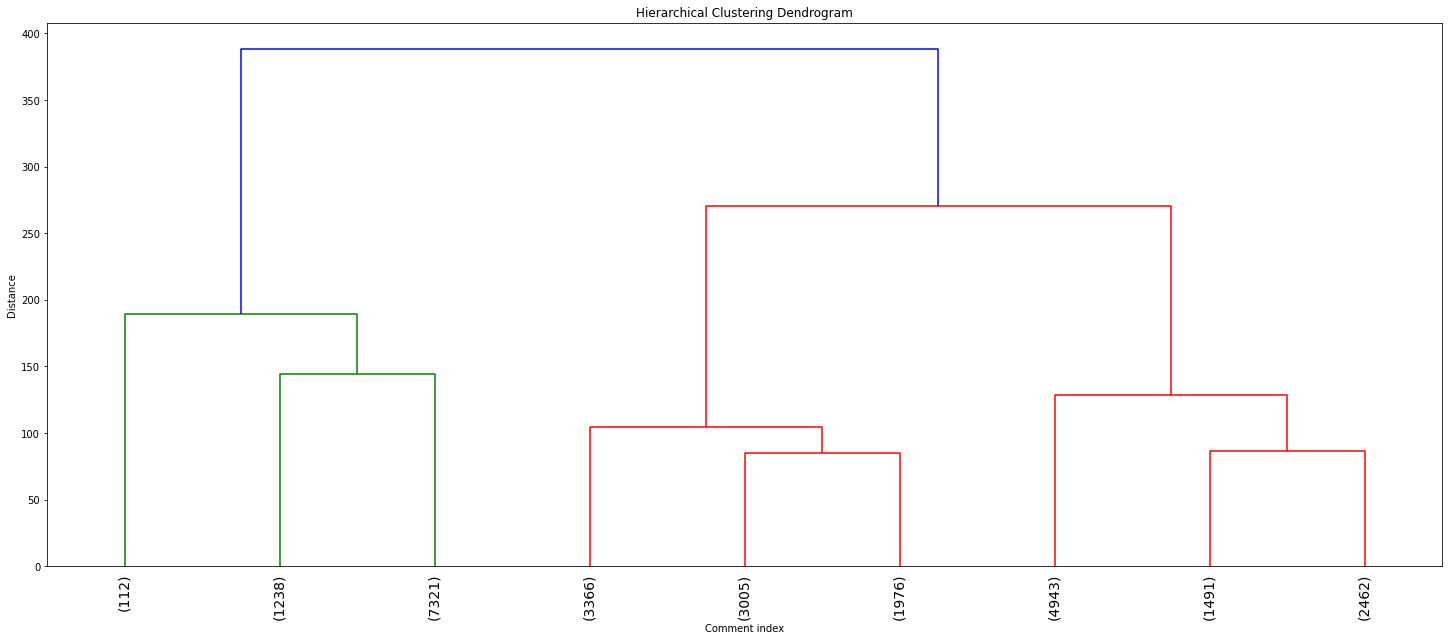

In [ ]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Comment index')
plt.ylabel('Distance')
sch.dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=lastp,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=14.,  # font size for the x axis labels
)
plt.show()

In [ ]:
#@markdown Select a number of clusters and linkage criterion. With cosine affinity linkage type can only be 'average'.
n_clusters= 9 #@param {type:"integer"}
linkage_type = "average" #@param ["ward", "average"]


In [ ]:
ac_clustering = AgglomerativeClustering(
    distance_threshold=None,
    n_clusters=n_clusters,
    affinity='cosine',
    linkage=linkage_type,
).fit(reduced_embeddings)

ac_clustering

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:469: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  children_ = out[:, :2].astype(np.int, copy=False)


In [ ]:
data['labels_agglomerative'] = ac_clustering.labels_

In [ ]:
labels = ac_clustering.labels_
s_score = silhouette_score(reduced_embeddings, labels)
(unique, counts) = np.unique(labels, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print("The silhouette score with {} clusters: {}".format(n_clusters, s_score))

print("Cluster cardinality with {} clusters:".format(n_clusters))
frequencies

The silhouette score with 9 clusters: 0.2966131567955017
Cluster cardinality with 9 clusters.


array([[   0, 7877],
       [   1, 6832],
       [   2, 1234],
       [   3,  589],
       [   4, 9104],
       [   5,   21],
       [   6,   71],
       [   7,   74],
       [   8,  112]])

### Dimensionality reduction for displaying clusters

In [ ]:
d2_embeddings = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=2,
    metric='cosine'
).fit_transform(reduced_embeddings)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1525: Depr

### Analyzing clusters

#### Display embeddings

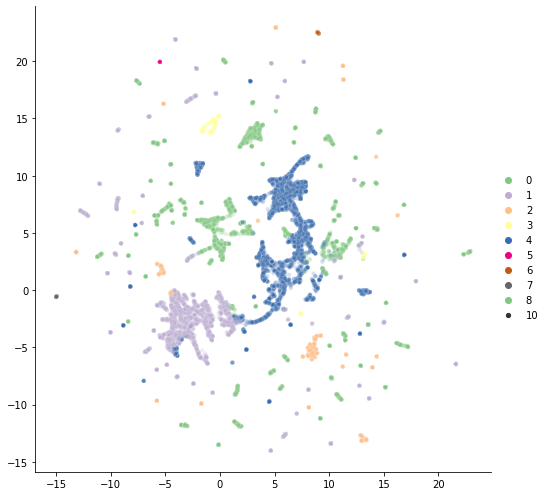

In [ ]:
import seaborn as sns

palette_param = "Accent"
alpha_param = 0.2


sns.relplot(x = d2_embeddings[:, 0], y = d2_embeddings[:, 1], size = 10, hue = labels, palette = palette_param,alpha = alpha_param,height = 7)

#### Embeddings Projector

Load embeddings.tsv and metadata.tsv into [Embeddings Projector](https://projector.tensorflow.org/).

#### Highlight single clusters

In [1]:
#@markdown Choose a cluster to highlight
cluster_num = 60 #@param {type: "integer"}

data['highlight'] = np.zeros(len(data.index))
data.loc[data['labels_agglomerative'] == cluster_num, 'highlight'] = 1

sns.relplot(x = d2_embeddings[:, 0], y = d2_embeddings[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)

NameError: ignored

In [ ]:
#@markdown Choose a cluster to print
cluster_number = 0 #@param {type: "integer"}
#@markdown Choose the number of samples to print
number_of_samples_to_print = 1000 #@param {type: "integer"}

data['labels_agglomerative'] = data['labels_agglomerative'].astype('category')
cluster = data[data['labels_agglomerative']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

print("Number of samples in the cluster:", cluster["text"].count())
cluster.tail(100)

Number of samples in the cluster: 7877


,Unnamed: 0,publishedAt,authorName,text,isReply,cleaned,labels_agglomerative,highlight
25306,25309,2015-12-16 23:51:38,Mac Guy3135,"Blast, my school will survive, just. it will be literally surrounded by water\n\n",1,"Blast, my school will survive, just. it will be literally surrounded by water\n\n",0,0.0
25317,25320,2015-06-21 15:30:47,SealClubbinFun,You Canadians are stupid. Watch the video. Just watch it. I dare you. I seen\nCanada. Do you need a label to know where you are?\n\n,1,You Canadians are stupid. Watch the video. Just watch it. I dare you. I seen\n. Do you need a label to know where you are?\n\n,0,0.0
25318,25321,2015-06-21 15:01:56,FuryanRogue,"@Allie KM They're too self-important to include us Canadians. :/ They seem to\nforget that we ARE bigger than them like, all the time.\n\n",1,"@ They're too self-important to include us Canadians. :/ They seem to\nforget that we ARE bigger than them like, all the time.\n\n",0,0.0
25319,25322,2015-06-19 04:41:48,Allie KM,"I think you missed the biggest country in North America, what was it? Right\nCANADA!\n\n",1,"I think you missed the biggest country in , what was it? Right\nCANADA!\n\n",0,0.0
25324,25327,2015-05-08 21:47:08,shawnhornett,@barry morgan Keep NY in NY.\n\n,1,@ Keep NY in NY.\n\n,0,0.0
...,...,...,...,...,...,...,...,...
25895,25898,2015-03-04 22:48:13,SEB VAR,Lol Canada stays entirely safe apparently.\n\n,0,Lol stays entirely safe apparently.\n\n,0,0.0
25899,25902,2015-08-06 16:01:34,Margus-Matis Roo,@Eknut .X you are a complete dumbass.. or you never heard of a country north\nof america -.- or its a troll...\n\n,1,@ you are a complete dumbass.. or you never heard of a country north\nof america -.- or its a troll...\n\n,0,0.0
25905,25908,2015-04-04 18:30:40,Gondwana,"@Eknut .X as usual you canadian dont care about germans, french, angolans and\nthe other 200 nationalities that weren't mentioned in the video either =P lol\n\n",1,"@ as usual you canadian dont care about germans, french, angolans and\nthe other 200 nationalities that weren't mentioned in the video either =P lol\n\n",0,0.0
25906,25909,2015-04-03 04:02:37,Gabriel Estéban Muñoz,"@100,000 Subscribers with NO VIDEOS?!?! They show a lot of cities around the\nworld, but just one of South America, this place is not just a jungle, that's\nwhat i mean.\n\n",1,"@100,000 Subscribers with NO VIDEOS?!?! They show a lot of cities around the\nworld, but just one of , this place is not just a jungle, that's\nwhat i mean.\n\n",0,0.0


#### Display top N similar comments

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def cos_sim(input_vectors):
    similarity = cosine_similarity(input_vectors)
    return similarity

cosine_similarity_matrix = cos_sim(np.array(embeddings))
print(cosine_similarity_matrix)

[[ 1.0000001   0.00968165  0.12730819 ... -0.04107115  0.24598774
   0.35544434]
 [ 0.00968165  1.0000002   0.02715601 ...  0.5482285   0.0241364
   0.05005576]
 [ 0.12730819  0.02715601  0.9999999  ...  0.20292106  0.16645284
   0.04606094]
 ...
 [-0.04107115  0.5482285   0.20292106 ...  1.0000002   0.02003537
   0.01877565]
 [ 0.24598774  0.0241364   0.16645284 ...  0.02003537  1.
   0.21783942]
 [ 0.35544434  0.05005576  0.04606094 ...  0.01877565  0.21783942
   1.        ]]


In [ ]:
#@markdown Select a comment by comment ID
top_comment = 2000 #@param {type:"integer"}

print("Original comment: {}".format(data["cleaned"][top_comment]))

this planet needs a good old fashioned culling....  
;o)




In [ ]:
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]


for i, value in enumerate(get_top_similar(data["cleaned"][top_comment], data["cleaned"].tolist(), cosine_similarity_matrix, 20)):
  print("Top {} similar comment: {}".format(i+1, value))

Top 1 similar comment: this planet needs a good old fashioned culling....  
;o)


Top 2 similar comment: This is actually a good thing. Mankind deserves to get fucked.


Top 3 similar comment: bye bye. World is overpopulated anyways!


Top 4 similar comment: We need less human beings on the planet anyway.


Top 5 similar comment: @ We need natural selection again wtf vaccines


Top 6 similar comment: Human dont care about it  
So human think like this:  
Hmm good land! Lets do this


Top 7 similar comment: This is why the world needs to go vegan


Top 8 similar comment: This is why we need a wall.


Top 9 similar comment: On the bright side, the threat of overpopulation would be dramatically
reduced.


Top 10 similar comment: God's way of weeding out the weak.... Earth is overpopulated as it is


Top 11 similar comment: Maybe if we take care of our planet then this won’t happen ☕️☕️☕️


Top 12 similar comment: would be better with a planet killer hitting it


Top 13 similar comment: I 